In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [152]:
srfc = cnst.ERA_MONTHLY_SRFC_SYNOP
pl = cnst.ERA_MONTHLY_PL_SYNOP
mcs = cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count_-50base.nc'
topo = cnst.network_data + 'data/ancils_python/gtopo_1min_afr.nc'
era5 = cnst.ERA5

fpath = cnst.network_data + 'figs/CLOVER/months/'

In [111]:
topo = xr.open_dataset(topo)
topo = topo['h'].sel(lon=slice(-17,-6), lat=slice(4.5,13))

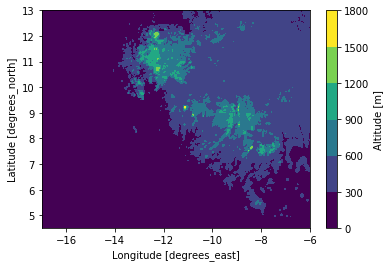

In [112]:
topo.plot.contourf()

In [84]:
ar = xr.open_dataarray(mcs)

In [150]:
def calc_trend(mean_years, method='mk', sig=False, coords=None):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=[coords[1], coords[0]])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0
            
    return dtrend

In [86]:
ar = ar.sel(lon=slice(-17,-6), lat=slice(4.5,13))

In [87]:
jjas = ar[(ar['time.month']>=6) & (ar['time.month']<=9)]

In [88]:
mcs_peryear = jjas.groupby('time.year').mean('time')

In [89]:
clim = jjas.groupby('time.year').mean('time').mean('year')

In [163]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(20,10))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [92]:
mcs_peryear25 = mcs_peryear[-25::]

In [93]:
mcs_peryear25

<xarray.DataArray 'tir' (year: 25, lat: 121, lon: 157)>
array([[[0.  , 0.  , ..., 0.  , 0.  ],
        [0.  , 0.  , ..., 0.  , 0.  ],
        ...,
        [0.25, 0.5 , ..., 0.5 , 0.5 ],
        [0.25, 0.25, ..., 0.5 , 0.5 ]],

       [[0.  , 0.  , ..., 0.  , 0.  ],
        [0.  , 0.  , ..., 0.  , 0.  ],
        ...,
        [0.5 , 0.5 , ..., 0.75, 0.75],
        [0.25, 0.5 , ..., 0.75, 0.5 ]],

       ...,

       [[0.  , 0.  , ..., 0.  , 0.  ],
        [0.  , 0.  , ..., 0.  , 0.  ],
        ...,
        [1.25, 1.25, ..., 0.25, 0.25],
        [1.25, 1.25, ..., 0.25, 0.5 ]],

       [[0.  , 0.  , ..., 0.  , 0.  ],
        [0.  , 0.  , ..., 0.  , 0.  ],
        ...,
        [1.25, 1.25, ..., 1.  , 1.  ],
        [1.25, 1.25, ..., 1.25, 1.25]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -16.970001 -16.899994 ... -6.119995 -6.050003
  * lat      (lat) float32 4.550003 4.6200027 4.6900024 ... 12.879997 12.949997
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2013 2014 2

In [94]:
clim25 = mcs_peryear25.mean('year')

In [95]:
trend25=calc_trend(mcs_peryear25)

Entering trend calc


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [97]:
trend25['slope'].values[trend['pval'].values>0.05] = 0

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


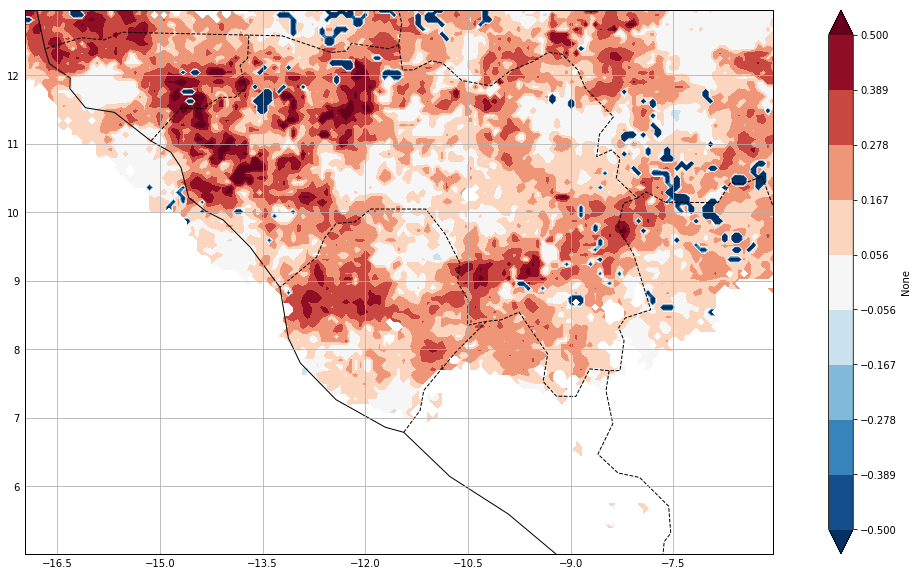

In [130]:
contour = {'x' : topo.lon.values, 'y': topo.lat.values, 'data': topo.values, 'levels': np.linspace(100,800,3), 'cmap':'Greys'}
draw_map(trend25['slope'].values*10, trend.lon, trend.lat, cmap='RdBu_r', levels=np.linspace(-0.5,0.5,10), extend='both')

In [106]:
topo['h'].values

array([[   0,    0,    0, ..., 1221, 1228, 1206],
       [   0,    0,    0, ..., 1199, 1193, 1149],
       [   0,    0,    0, ..., 1138, 1148, 1159],
       ...,
       [   0,    0,    0, ...,  211,  215,  232],
       [   0,    0,    0, ...,  191,  192,  198],
       [   0,    0,    0, ...,  171,  168,  189]], dtype=int16)

In [173]:
era5_dat = xr.open_mfdataset(era5 + 'pressure_levels/*_02_pl.nc')

In [174]:
era5_dat

<xarray.Dataset>
Dimensions:    (latitude: 73, level: 19, longitude: 133, time: 1612)
Coordinates:
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 4.75 4.5 4.25 4.0
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 2000-02-01T12:00:00 ... 2012-03-02T03:00:00
Data variables:
    pv         (time, level, latitude, longitude) float32 dask.array<shape=(1612, 19, 73, 133), chunksize=(124, 19, 73, 133)>
    t          (time, level, latitude, longitude) float32 dask.array<shape=(1612, 19, 73, 133), chunksize=(124, 19, 73, 133)>
    q          (time, level, latitude, longitude) float32 dask.array<shape=(1612, 19, 73, 133), chunksize=(124, 19, 73, 133)>
    w          (time, level, latitude, longitude) float32 dask.array<shape=(1612, 19, 73, 133), chunksize=(124, 19, 73, 133)>
    d          (time, level, latitude, longitude) float32 da

In [175]:
t2mean = era5_dat['q'].sel(level=875).groupby('time.year').mean('time')

In [176]:
t2mean = t2mean.load()

In [179]:
t2 = t2mean.sel(longitude=slice(-17,-6), latitude=slice(13,4.5))*1000#-273.15

In [180]:
t2

<xarray.DataArray 'q' (year: 13, latitude: 35, longitude: 45)>
array([[[ 3.317315,  3.322129, ...,  2.14161 ,  2.141702],
        [ 3.465217,  3.46259 , ...,  2.196147,  2.197455],
        ...,
        [11.55579 , 11.473558, ..., 10.939713, 10.509648],
        [11.669195, 11.602594, ..., 10.559562, 10.251594]],

       [[ 2.363162,  2.503165, ...,  1.957206,  1.95068 ],
        [ 2.530509,  2.665847, ...,  1.993423,  1.993475],
        ...,
        [12.526714, 12.482754, ..., 12.171958, 11.925918],
        [12.715975, 12.707834, ..., 11.859926, 11.714478]],

       ...,

       [[ 3.622744,  3.751846, ...,  3.16927 ,  3.187738],
        [ 3.723384,  3.852953, ...,  3.294492,  3.303808],
        ...,
        [12.924831, 12.919633, ..., 12.58693 , 12.389579],
        [13.113555, 13.096432, ..., 12.429985, 12.320442]],

       [[ 3.288635,  3.367793, ...,  3.103222,  3.09435 ],
        [ 3.380063,  3.468345, ...,  3.132554,  3.119349],
        ...,
        [11.764809, 11.789046, ..., 12.1

In [188]:
t2trend = calc_trend(t2, coords=['longitude', 'latitude'])

Entering trend calc


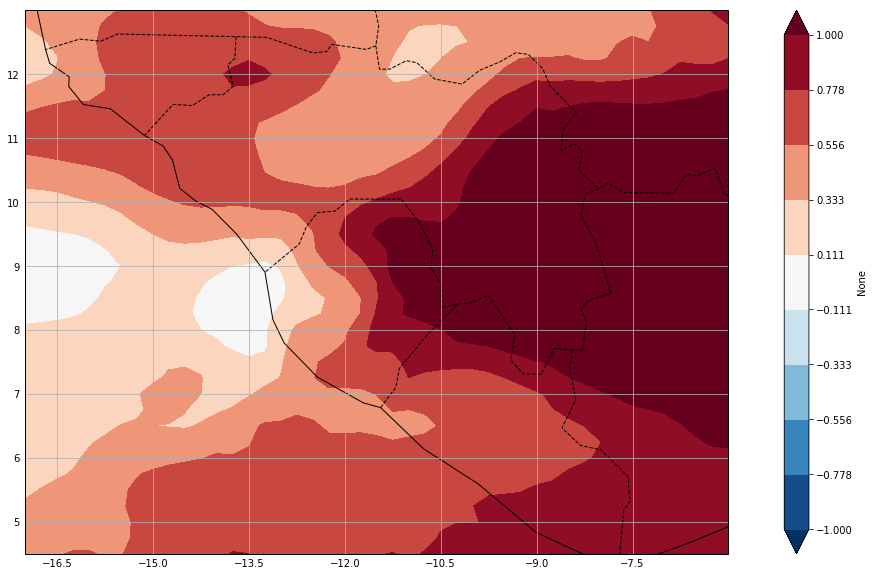

In [189]:
draw_map(t2trend['slope'].values*10, t2.longitude, t2.latitude, cmap='RdBu_r', levels=np.linspace(-1,1,10), extend='both')

In [166]:
t2trend

<xarray.Dataset>
Dimensions:            (allpoints_level_0: 35, allpoints_level_1: 45)
Coordinates:
  * allpoints_level_0  (allpoints_level_0) float64 4.5 4.75 5.0 ... 12.75 13.0
  * allpoints_level_1  (allpoints_level_1) float64 -17.0 -16.75 ... -6.25 -6.0
Data variables:
    slope              (allpoints_level_0, allpoints_level_1) float64 0.007943 ... 0.03795
    pval               (allpoints_level_0, allpoints_level_1) float64 0.149 ... 0.1238
    ind                (allpoints_level_0, allpoints_level_1) int64 0 0 ... 0 0

In [186]:
t2trend['slope'].values[t2trend['pval'].values>0.05] = 0